# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import tensorflow as tf
import os
import random
import datetime

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data

In [3]:
data_path = 'https://raw.githubusercontent.com/antbartash/max_temp/master/data/data2.csv'
data = pd.read_csv(data_path, index_col=0)
data['DATE'] = data['DATE'].astype('datetime64[ns]')

print(data.shape)
data.head()

(40898, 4)


,STATION,NAME,DATE,TMAX
0,USW00012916,"NEW ORLEANS AIRPORT, LA US",2010-01-01,12.2
1,USW00012916,"NEW ORLEANS AIRPORT, LA US",2010-01-02,10.6
2,USW00012916,"NEW ORLEANS AIRPORT, LA US",2010-01-03,8.3
3,USW00012916,"NEW ORLEANS AIRPORT, LA US",2010-01-04,6.1
4,USW00012916,"NEW ORLEANS AIRPORT, LA US",2010-01-05,6.1


In [4]:
# only 1 station
# data = data[data['STATION'] == 'USW00012916'].reset_index(drop=True)
# data = data[['DATE', 'TMAX']]

data = data[['STATION', 'DATE', 'TMAX']]

# add sine and cosine transforms to add periodicality
doy = data['DATE'].dt.dayofyear / 365.2425
data['Year_sin'] = np.sin(doy * 2 * np.pi)
data['Year_cos'] = np.cos(doy * 2 * np.pi)

print(data.shape)
data.head()

(40898, 5)


,STATION,DATE,TMAX,Year_sin,Year_cos
0,USW00012916,2010-01-01,12.2,0.017202,0.999852
1,USW00012916,2010-01-02,10.6,0.034399,0.999408
2,USW00012916,2010-01-03,8.3,0.051585,0.998669
3,USW00012916,2010-01-04,6.1,0.068757,0.997633
4,USW00012916,2010-01-05,6.1,0.085908,0.996303


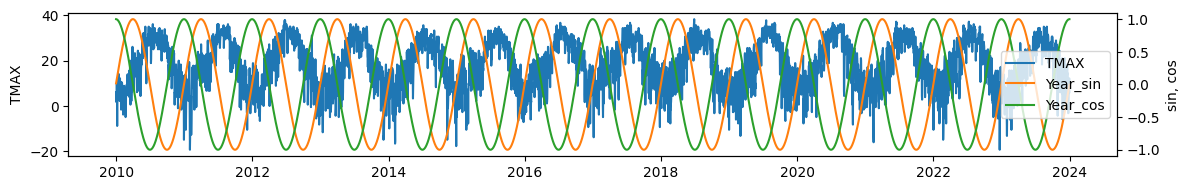

In [5]:
# Station TMAX plot

STATION_IDX = 2
data_plot = data[data['STATION'] == data['STATION'].unique()[STATION_IDX]].copy()

fix, ax = plt.subplots(figsize=(12, 2))
ax.plot(data_plot['DATE'], data_plot['TMAX'], label='TMAX')

ax2 = ax.twinx()
ax2.plot(np.nan, np.nan, label='TMAX')
ax2.plot(data_plot['DATE'], data_plot['Year_sin'], label='Year_sin')
ax2.plot(data_plot['DATE'], data_plot['Year_cos'], label='Year_cos')

ax.set_ylabel('TMAX')
ax2.set_ylabel('sin, cos')
plt.legend()
plt.tight_layout()
plt.show()

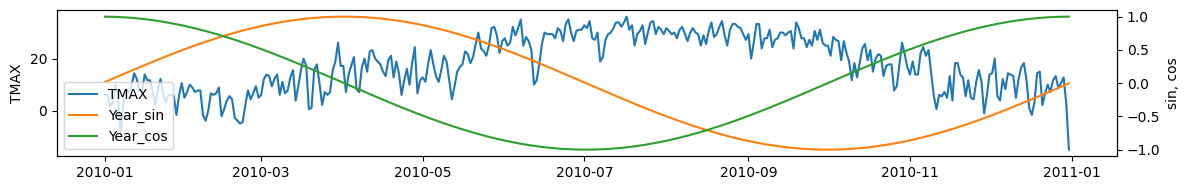

In [6]:
# Station TMAX plot
PLOT_YEAR = 2010

fix, ax = plt.subplots(figsize=(12, 2))
ax.plot(data_plot.loc[data_plot['DATE'].dt.year==PLOT_YEAR, 'DATE'],
        data_plot.loc[data_plot['DATE'].dt.year==PLOT_YEAR, 'TMAX'],
        label='TMAX')

ax2 = ax.twinx()
ax2.plot(np.nan, np.nan, label='TMAX')
ax2.plot(data_plot.loc[data_plot['DATE'].dt.year==PLOT_YEAR, 'DATE'],
        data_plot.loc[data_plot['DATE'].dt.year==PLOT_YEAR, 'Year_sin'],
        label='Year_sin')
ax2.plot(data_plot.loc[data_plot['DATE'].dt.year==PLOT_YEAR, 'DATE'],
        data_plot.loc[data_plot['DATE'].dt.year==PLOT_YEAR, 'Year_cos'],
        label='Year_cos')

ax.set_ylabel('TMAX')
ax2.set_ylabel('sin, cos')
plt.legend()
plt.tight_layout()
plt.show()

# Data preprocessing

## Train/valid/test split

In [7]:
train_df = data.loc[data['DATE'].dt.year <= 2021].reset_index(drop=True).copy()
valid_df = data.loc[data['DATE'].dt.year == 2022].reset_index(drop=True).copy()
test_df = data.loc[data['DATE'].dt.year == 2023].reset_index(drop=True).copy()

print(f'Train: {train_df.shape}')
print(f'Valid: {valid_df.shape}')
print(f'Test: {test_df.shape}')

Train: (35058, 5)
Valid: (2920, 5)
Test: (2920, 5)


## Scaling

In [8]:
# train_df.set_index('DATE', inplace=True)
# valid_df.set_index('DATE', inplace=True)
# test_df.set_index('DATE', inplace=True)
train_df.drop(columns=['DATE'], inplace=True)
valid_df.drop(columns=['DATE'], inplace=True)
test_df.drop(columns=['DATE'], inplace=True)

# keep station to drop mixed windows later (encode to avoid errors from scaler)
encoder = OrdinalEncoder()
encoder.fit(train_df[['STATION']])
train_df['STATION'] = encoder.transform(train_df[['STATION']])[:, 0]
valid_df['STATION'] = encoder.transform(valid_df[['STATION']])[:, 0]
test_df['STATION'] = encoder.transform(test_df[['STATION']])[:, 0]

# scaling
scaler = StandardScaler()
scaler.fit(train_df)
train_df = pd.DataFrame(scaler.transform(train_df),
                        columns=scaler.feature_names_in_, index=train_df.index)
valid_df = pd.DataFrame(scaler.transform(valid_df),
                        columns=scaler.feature_names_in_, index=valid_df.index)
test_df = pd.DataFrame(scaler.transform(test_df),
                       columns=scaler.feature_names_in_, index=test_df.index)

train_df.head()

,STATION,TMAX,Year_sin,Year_cos
0,-1.091014,-0.747812,0.024402,1.414016
1,-1.091014,-0.896450,0.048723,1.413388
2,-1.091014,-1.110117,0.073029,1.412342
3,-1.091014,-1.314495,0.097314,1.410878
4,-1.091014,-1.314495,0.121571,1.408997


## TF Dataset

In [9]:
def create_dataset(data, target_col, source_col, seq_length):
  input_data = data[:-seq_length]
  # adding source_col to target allows to drop samples with features and target
  # from diff sources (source_col will be dropped from the target later)
  targets = data[[source_col, target_col]][seq_length:]
  dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
      input_data, targets,
      sequence_length=seq_length,
      sequence_stride=1,
      batch_size=32,
      shuffle=False,
      seed=42
    )
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:seq_length])  # First sequence: steps [0-13]
    # Corresponding target: step 14
    assert np.array_equal(targets[0, 1], data.loc[seq_length, target_col])
    break
  return dataset

train_ds = create_dataset(train_df, 'TMAX', 'STATION', 14)
valid_ds = create_dataset(valid_df, 'TMAX', 'STATION', 14)
test_ds = create_dataset(test_df, 'TMAX', 'STATION', 14)

### Check

In [10]:
train_df.head(15)

,STATION,TMAX,Year_sin,Year_cos
0,-1.091014,-0.747812,0.024402,1.414016
1,-1.091014,-0.896450,0.048723,1.413388
2,-1.091014,-1.110117,0.073029,1.412342
3,-1.091014,-1.314495,0.097314,1.410878
4,-1.091014,-1.314495,0.121571,1.408997
5,-1.091014,-1.110117,0.145791,1.406699
6,-1.091014,-0.329766,0.169968,1.403984
7,-1.091014,-1.723250,0.194095,1.400854
8,-1.091014,-1.621062,0.218165,1.397309
9,-1.091014,-1.472423,0.242170,1.393351


In [11]:
list(train_ds.unbatch().as_numpy_iterator())[0]

(array([[-1.09101358, -0.74781154,  0.02440159,  1.41401556],
        [-1.09101358, -0.89644984,  0.04872265,  1.41338789],
        [-1.09101358, -1.1101174 ,  0.07302932,  1.41234198],
        [-1.09101358, -1.31449507,  0.09731439,  1.41087814],
        [-1.09101358, -1.31449507,  0.12157069,  1.4089968 ],
        [-1.09101358, -1.1101174 ,  0.14579103,  1.40669853],
        [-1.09101358, -0.32976632,  0.16996825,  1.40398399],
        [-1.09101358, -1.72325039,  0.19409519,  1.40085399],
        [-1.09101358, -1.62106156,  0.21816472,  1.39730947],
        [-1.09101358, -1.47242326,  0.24216971,  1.39335146],
        [-1.09101358, -1.00792857,  0.26610305,  1.38898114],
        [-1.09101358, -0.54343388,  0.28995767,  1.38419981],
        [-1.09101358, -0.95218921,  0.3137265 ,  1.37900887],
        [-1.09101358, -0.38550568,  0.33740252,  1.37340987]]),
 array([-1.09101358, -0.48769452]))

## Different sources

### Problem

In [12]:
# some samples has info from different sources in features (the first column)
list(train_ds.unbatch().as_numpy_iterator())[4382]

(array([[-1.09101358,  0.74786136, -0.00582654,  1.4142125 ],
        [ 1.52765803, -1.47242326,  0.02440159,  1.41401556],
        [ 1.52765803, -1.77898976,  0.04872265,  1.41338789],
        [ 1.52765803, -2.40141264,  0.07302932,  1.41234198],
        [ 1.52765803, -1.98336742,  0.09731439,  1.41087814],
        [ 1.52765803, -1.98336742,  0.12157069,  1.4089968 ],
        [ 1.52765803, -1.77898976,  0.14579103,  1.40669853],
        [ 1.52765803, -1.62106156,  0.16996825,  1.40398399],
        [ 1.52765803, -1.82543923,  0.19409519,  1.40085399],
        [ 1.52765803, -1.98336742,  0.21816472,  1.39730947],
        [ 1.52765803, -2.08555625,  0.24216971,  1.39335146],
        [ 1.52765803, -1.93691795,  0.26610305,  1.38898114],
        [ 1.52765803, -1.72325039,  0.28995767,  1.38419981],
        [ 1.52765803, -1.72325039,  0.3137265 ,  1.37900887]]),
 array([ 1.52765803, -1.36094454]))

In [13]:
# some samples has info from different sources in target (the first column)
list(train_ds.unbatch().as_numpy_iterator())[4369]

(array([[-1.09101358,  0.5434837 , -0.31933006,  1.37768853],
        [-1.09101358, -0.12538866, -0.29558309,  1.38297857],
        [-1.09101358, -0.89644984, -0.27174863,  1.38785937],
        [-1.09101358, -0.85000038, -0.24783372,  1.39232948],
        [-1.09101358, -0.32976632, -0.22384546,  1.39638759],
        [-1.09101358, -0.12538866, -0.19979093,  1.40003248],
        [-1.09101358,  0.44129487, -0.17567725,  1.40326309],
        [-1.09101358,  0.49703423, -0.15151157,  1.40607845],
        [-1.09101358,  0.44129487, -0.12730102,  1.40847774],
        [-1.09101358,  0.5434837 , -0.10305279,  1.41046024],
        [-1.09101358,  0.5434837 , -0.07877403,  1.41202537],
        [-1.09101358,  0.64567253, -0.05447195,  1.41317266],
        [-1.09101358,  0.80360072, -0.03015372,  1.41390177],
        [-1.09101358,  0.74786136, -0.00582654,  1.4142125 ]]),
 array([ 1.52765803, -1.47242326]))

In [14]:
def filter_mixed_windows(dataset):
    def is_valid_window(inputs, targets):
        # Extract the first feature (station) from inputs and targets
        input_station_ids = inputs[:, :, 0]  # Shape: (batch_size, sequence_length)
        target_station_ids = targets[:, 0]  # Shape: (batch_size)

        # Check if all station IDs in the inputs are the same
        input_same_station = tf.reduce_all(tf.reduce_max(input_station_ids, axis=1) == tf.reduce_min(input_station_ids, axis=1))

        # Check if the target's station ID matches the input station ID
        target_matches_input = tf.reduce_all(tf.reduce_max(input_station_ids, axis=1) == target_station_ids)

        # Only keep windows where both conditions are true
        return tf.logical_and(input_same_station, target_matches_input)

    # Filter the dataset
    filtered_dataset = dataset.filter(is_valid_window)
    return filtered_dataset

train_ds = filter_mixed_windows(train_ds)
valid_ds = filter_mixed_windows(valid_ds)
test_ds = filter_mixed_windows(test_ds)

### Check

In [15]:
# different sources problem (features) fixed
list(filter_mixed_windows(train_ds).unbatch().as_numpy_iterator())[4382]

(array([[ 1.52765803, -1.72325039,  0.7398862 ,  1.20531056],
        [ 1.52765803, -1.82543923,  0.76051095,  1.19240712],
        [ 1.52765803, -1.51887273,  0.78091067,  1.17915085],
        [ 1.52765803, -1.62106156,  0.80107932,  1.16554564],
        [ 1.52765803, -1.67680093,  0.82101092,  1.15159555],
        [ 1.52765803, -1.82543923,  0.84069959,  1.13730468],
        [ 1.52765803, -1.77898976,  0.86013949,  1.12267728],
        [ 1.52765803, -1.62106156,  0.87932488,  1.10771766],
        [ 1.52765803, -1.36094454,  0.89825006,  1.09243026],
        [ 1.52765803, -1.77898976,  0.91690946,  1.07681961],
        [ 1.52765803, -1.62106156,  0.93529753,  1.06089031],
        [ 1.52765803, -1.62106156,  0.95340885,  1.04464709],
        [ 1.52765803, -1.88117859,  0.97123804,  1.02809474],
        [ 1.52765803, -1.51887273,  0.98877985,  1.01123818]]),
 array([ 1.52765803, -1.47242326]))

In [16]:
list(train_ds.unbatch().as_numpy_iterator())[4369]

(array([[ 1.52765803, -1.05437804,  0.45414617,  1.33935605],
        [ 1.52765803, -1.4166839 ,  0.47711924,  1.33134764],
        [ 1.52765803, -1.4166839 ,  0.49995114,  1.32294526],
        [ 1.52765803, -1.2587557 ,  0.52263512,  1.31415141],
        [ 1.52765803, -1.47242326,  0.54516445,  1.30496868],
        [ 1.52765803, -0.95218921,  0.56753247,  1.2953998 ],
        [ 1.52765803, -0.58988335,  0.58973257,  1.2854476 ],
        [ 1.52765803, -1.00792857,  0.61175818,  1.27511501],
        [ 1.52765803, -1.51887273,  0.63360276,  1.26440511],
        [ 1.52765803, -1.36094454,  0.65525987,  1.25332105],
        [ 1.52765803, -2.34567328,  0.67672309,  1.24186613],
        [ 1.52765803, -2.50360148,  0.69798607,  1.23004372],
        [ 1.52765803, -1.98336742,  0.71904252,  1.21785733],
        [ 1.52765803, -1.72325039,  0.7398862 ,  1.20531056]]),
 array([ 1.52765803, -1.82543923]))

## Drop source column

In [17]:
def drop_first_column(feature, label):
    feature = feature[:, :, 1:]  # Keep all rows, drop the first column
    label = label[:, 1:]    # Keep all rows, drop the first column
    return feature, label

train_ds = train_ds.map(drop_first_column)
valid_ds = valid_ds.map(drop_first_column)
test_ds = test_ds.map(drop_first_column)

# Final dataset

In [18]:
for element in train_ds.take(1):
    print(f'Features batch shape: {element[0].shape}')
    print(f'Target batch shape: {element[1].shape}')

Features batch shape: (32, 14, 3)
Target batch shape: (32, 1)


In [19]:
# 1st row features
element[0][0]

<tf.Tensor: shape=(14, 3), dtype=float64, numpy=
array([[-0.74781154,  0.02440159,  1.41401556],
       [-0.89644984,  0.04872265,  1.41338789],
       [-1.1101174 ,  0.07302932,  1.41234198],
       [-1.31449507,  0.09731439,  1.41087814],
       [-1.31449507,  0.12157069,  1.4089968 ],
       [-1.1101174 ,  0.14579103,  1.40669853],
       [-0.32976632,  0.16996825,  1.40398399],
       [-1.72325039,  0.19409519,  1.40085399],
       [-1.62106156,  0.21816472,  1.39730947],
       [-1.47242326,  0.24216971,  1.39335146],
       [-1.00792857,  0.26610305,  1.38898114],
       [-0.54343388,  0.28995767,  1.38419981],
       [-0.95218921,  0.3137265 ,  1.37900887],
       [-0.38550568,  0.33740252,  1.37340987]])>

In [20]:
# 1st row target
element[1][0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.48769452])>

# Baseline/test model

In [21]:
BATCH_SIZE = 128
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
valid_ds = valid_ds.unbatch().batch(BATCH_SIZE)
test_ds = test_ds.unbatch().batch(BATCH_SIZE)

train_num_batches = len(list(train_ds))
valid_num_batches = len(list(valid_ds))
test_num_batches = len(list(test_ds))
print(train_num_batches, valid_num_batches, test_num_batches)

train_ds = train_ds.repeat()
valid_ds = valid_ds.repeat()
test_ds = test_ds.repeat()

272 21 21


In [ ]:
INPUT_SHAPE = (14, 3, )

# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=100, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=25
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history = model.fit(
    train_ds, epochs=1000, validation_data=valid_ds,
    steps_per_epoch=train_num_batches, validation_steps=valid_num_batches,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback]
)

Epoch 1/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.5108 - mean_squared_error: 0.4112 - val_loss: 0.4706 - val_mean_squared_error: 0.3547 - learning_rate: 0.0010
Epoch 2/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4031 - mean_squared_error: 0.2807 - val_loss: 0.4696 - val_mean_squared_error: 0.3549 - learning_rate: 0.0010
Epoch 3/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.4004 - mean_squared_error: 0.2766 - val_loss: 0.4662 - val_mean_squared_error: 0.3519 - learning_rate: 0.0010
Epoch 4/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.3998 - mean_squared_error: 0.2755 - val_loss: 0.4621 - val_mean_squared_error: 0.3477 - learning_rate: 0.0010
Epoch 5/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.3991 - mean_squared_error: 0.2743 - val_loss: 0.4578 - val_mean_squared_error: 0.3433 - learning_rate: 0.0010
Epoch 6/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.3981 - mean_squared_error: 0.2729 - val_loss: 0.4543 - val_m